1. takes 2 data set, one is 'merian' and the other is 'truth'
2. see what is missing from 'merian' (completeness)
3. see what is in 'merian' but not 'truth' (purity)

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from astropy.io import fits

import random

In [3]:
f = '/Users/josephwick/Documents/Data/merian/COSMOS2015_r23.6_SOM_v3.fits'
wtsf = '../speczWeights/specz-weights.npy'

In [4]:
def getSpeczData(fname):
    data = fits.open(fname)[1].data
    data = data[data['z_type']==1]

    aphot = 10**(-0.4 * np.c_[data['a_g'], data['a_r'], data['a_i'], 
                                data['a_z'], data['a_y']])

    spec_data = np.c_[data['g_cmodel_mag'],
                     data['r_cmodel_mag'],
                     data['i_cmodel_mag'],
                     data['z_cmodel_mag'],
                     data['y_cmodel_mag']] / aphot

    err = np.c_[data['g_cmodel_flux_err'],
                      data['r_cmodel_flux_err'],
                      data['i_cmodel_flux_err'],
                      data['z_cmodel_flux_err'],
                      data['y_cmodel_flux_err']] / aphot

    mask_calib = (err > 0.) & np.isfinite(err) & np.isfinite(spec_data)

    # remove any sources with non-detections
    sel = mask_calib.sum(axis=1) == 5
    spec_data = spec_data[sel]
    
    # weight 
    wts = np.load(wtsf)
    spec_data_wtd = weightData(spec_data, wts)
    
    # masses
    masses = data['mass_cosmos']
    masses = masses[sel]
    
    return spec_data_wtd, masses

In [5]:
def weightData(data, wts):
    mag_data_wtd = []
    for i in range(5):
        mag_data_wtd.append(data[:,1] *wts )
    
    return mag_data_wtd

In [6]:
# merian range:
#   z between 0.058 and 0.1
#   log mass between 8 and 9 solar masses

In [7]:
def getMerianRaw(fname):

    data = fits.open(fname)[1].data

    aphot = 10**(-0.4 * np.c_[data['a_g'], data['a_r'], data['a_i'], 
                                data['a_z'], data['a_y']])

    broad_data = np.c_[data['g_cmodel_mag'],
                     data['r_cmodel_mag'],
                     data['i_cmodel_mag'],
                     data['z_cmodel_mag'],
                     data['y_cmodel_mag']] / aphot

    err = np.c_[data['g_cmodel_flux_err'],
                      data['r_cmodel_flux_err'],
                      data['i_cmodel_flux_err'],
                      data['z_cmodel_flux_err'],
                      data['y_cmodel_flux_err']] / aphot

    mask_calib = (err > 0.) & np.isfinite(err) & np.isfinite(broad_data)

    # remove any sources with non-detections
    sel = mask_calib.sum(axis=1) == 5
    broad_data = broad_data[sel]

    zees = data['z']
    zees = zees[sel]

    masses = data['mass_cosmos']
    masses = masses[sel]
    IDs = data['HSC_object_id']
    IDs = IDs[sel]
    
    #reshape 
    merian_data = []
    for i in range(5):
        merian_data.append( broad_data[:,1] )
        
    # zees and mass
    sel = np.where( 0.058 <= zees)
    zees = zees[sel]
    for i in range(len(merian_data)):
        merian_data[i] = merian_data[i][sel[0]]
    masses=masses[sel]
    IDs = IDs[sel]
        
    sel = np.where( zees <= 0.1)
    zees = zees[sel]
    for i in range(len(merian_data)):
        merian_data[i] = merian_data[i][sel[0]]
    masses = masses[sel]
    IDs = IDs[sel]
    
    # make mass/z cut
    sel = np.where(8 <= masses)
    masses = masses[sel]
    IDs = IDs[sel]
    for i in range(len(merian_data)):
        merian_data[i] = merian_data[i][sel]
    
    sel = np.where(masses <= 9)
    masses = masses[sel]
    IDs = IDs[sel]
    for i in range(len(merian_data)):
        merian_data[i] = merian_data[i][sel]
        
    return merian_data, masses, IDs

In [8]:
# first, completeness
# remove some things according to their mass

In [9]:
def isDetected(m) :
    p = 0.2 + 0.8*(m-8)
    r = random.uniform(0,1)
    
    if r>p:
        return False
    else:
        return True

In [10]:
def makeCompletenessCut(data, ms, ids):
    remove = []
    data_c = []
    for i in range(len(data[1])):
        isDet = isDetected(ms[i])
        if not isDet:
            remove.append(i)

    for i in range(len(data)):
        data_c.append(np.delete(data[i], remove))
    masses = np.delete(ms, remove)
    IDs = np.delete(ids, remove)

    return data_c, masses, IDs

In [11]:
# now, purity
# add in some random galaxies from z~1

In [12]:
def addImpurity(m):
    p = 0.6 +0.3*(m-8)
    r = random.uniform(0,1)
    
    if r>p:
        return True
    else:
        return False

In [13]:
def makePurityCut(dataC, fname, masses, ids):

    data = fits.open(fname)[1].data
    data = data[data['z'] > 0.8]
    additives = data[data['z'] < 1.2]
    data_p=[]
    gees=[]
    mazzes = np.copy(masses)
    IDs = np.copy(ids)
    added_masses=[]
    added_ids=[]
    
    for i in range(len(dataC[1])):
        addImp = addImpurity(masses[i])
        if addImp:
            j = random.randint(0, len(additives)-1)
            g = np.c_[additives['g_cmodel_mag'][j], additives['r_cmodel_mag'][j], additives['i_cmodel_mag'][j], additives['z_cmodel_mag'][j], 
                      additives['g_cmodel_mag'][j]]
            gees.append(g[0])
            added_masses.append(masses[i])
            added_ids.append(additives['HSC_object_id'][i])
            mazzes = np.append(mazzes, masses[i])
            IDs = np.append(IDs, additives['HSC_object_id'][i])
       
    gees = np.array(gees)
    for k in range(len(dataC)):
        data_p.append(np.append(dataC[k], gees[:,k]))
    
    return data_p, added_masses, mazzes, IDs

In [14]:
# representative
data_specz, massesSpec = getSpeczData(f)

In [15]:
# merian
rawMerian, rawMasses, rawIDs = getMerianRaw(f)
merianC, massesC, IDsC = makeCompletenessCut(rawMerian, rawMasses, rawIDs)
data_merian, added_masses, massesCP, IDsCP = makePurityCut(merianC, f, massesC, IDsC)

In [16]:
# hsc mag data for each galaxy
data_merian = np.array(data_merian)
data_specz = np.array(data_specz)

# Figure

In [17]:
# first we need to bin by mass
nbins = 10
slices = np.linspace(rawMasses.min(), rawMasses.max(), nbins, True)

cIdxs = np.digitize(massesC, slices)-1
rawIdxs = np.digitize(rawMasses, slices)-1
addedIdxs = np.digitize(added_masses, slices)-1
cpIdxs = np.digitize(massesCP, slices)-1

specIdxs = np.digitize(massesSpec, slices)-1

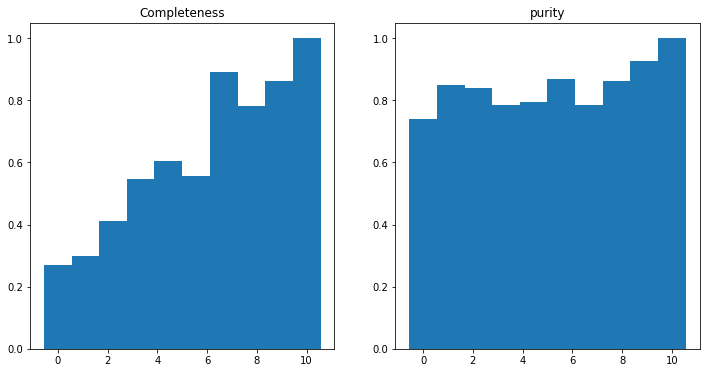

In [18]:
# completeness is len(merianC)/len(rawMerian)
# purity is len(rawMerian)/len(rawMerian+added)

comps= []
purs = []
for i in range(nbins):
    b_c = np.array(data_merian[0])[np.where(cIdxs == i)]
    b_raw = np.array(rawMerian[0])[np.where(rawIdxs == i)]
    b_am = np.array(added_masses)[np.where(addedIdxs == i)]
    b_cp = np.array(massesCP)[np.where(cpIdxs == i)]
    
    comps.append(len(b_c)/len(b_raw))
    purs.append(1-(len(b_am)/len(b_cp)))
    
fig, axs = plt.subplots(1,2, figsize=(12,6))

x = np.linspace(0,nbins, nbins)
axs[0].bar(x,comps, width=1.12)

axs[1].bar(x,purs, width=1.12)

# prettify
axs[0].title.set_text('Completeness')
axs[1].title.set_text('purity')

plt.savefig('CompPur.jpg')

# Now recreating the figure without knowing the truth 

In [19]:
# Our two data sets
# truth  is rawMerian, rawMass, rawIDs
# 'merian' is data_merian, massesCP, IDsCP

In [20]:
# first we need to bin by mass
nbins = 10
slices = np.linspace(rawMasses.min(), rawMasses.max(), nbins, True)

rawIdxs = np.digitize(rawMasses, slices)-1
cpIdxs = np.digitize(massesCP, slices)-1

In [21]:
comps_2 = []
purs_2 = []
for i in range(nbins):
    bIDs_raw = np.array(rawIDs)[np.where(rawIdxs == i)]
    bIDs_mer = np.array(IDsCP)[np.where(cpIdxs == i)]
    
    a = 0     # number of merian galaxies in truth table 
    b = 0     # number of merian galaxies NOT in truth table 
    for ID in bIDs_mer:
        if ID in bIDs_raw:
            a+=1
        else: 
            b+=1
            
    c = 0     # number of truth galaxies NOT in merian
    for ID in bIDs_raw:
        if ID not in bIDs_mer:
            c += 1
            
    comps_2.append(a/len(bIDs_raw))
    purs_2.append(1 - (b/len(bIDs_mer)))

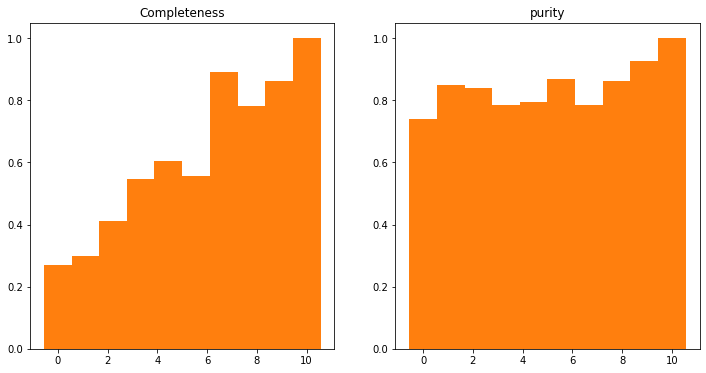

In [22]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

x = np.linspace(0,nbins, nbins)
axs[0].bar(x,comps_2, width=1.12, color='tab:orange')

axs[1].bar(x,purs_2, width=1.12, color='tab:orange')

# prettify
axs[0].title.set_text('Completeness')
axs[1].title.set_text('purity')

plt.savefig('CompPur.jpg')

# Compare the figs

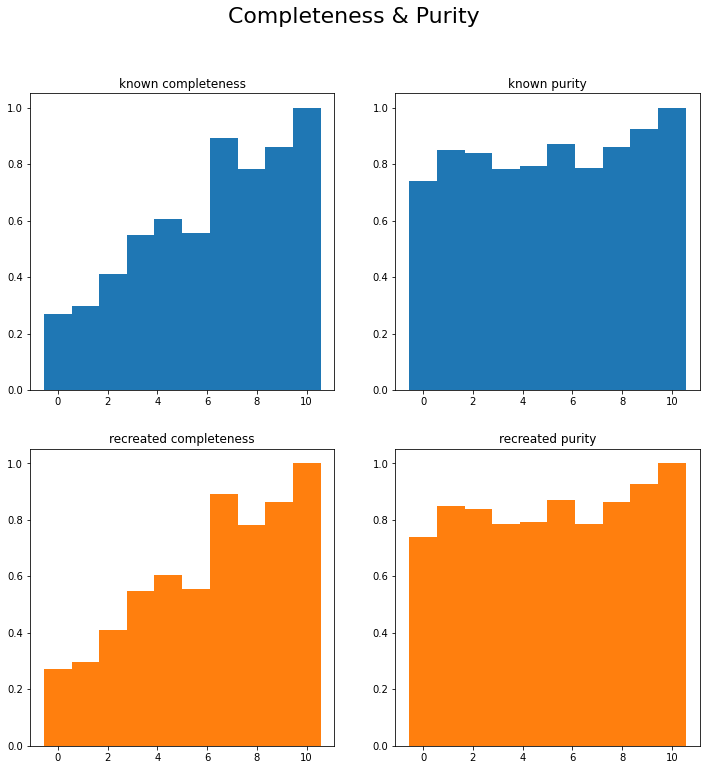

In [23]:
fig, axs = plt.subplots(2,2, figsize=(12,12))

x = np.linspace(0, nbins, nbins)
axs[0,0].bar(x, comps, width=1.12, color='tab:blue')
axs[0,1].bar(x, purs, width=1.12, color='tab:blue')

axs[1,0].bar(x, comps_2, width=1.12, color='tab:orange')
axs[1,1].bar(x, purs_2, width=1.12, color='tab:orange')

# prettify 
plt.suptitle('Completeness & Purity', fontsize=22)
axs[0,0].title.set_text('known completeness')
axs[0,1].title.set_text('known purity')
axs[1,0].title.set_text('recreated completeness')
axs[1,1].title.set_text('recreated purity')

plt.savefig('compPur2.0.jpg')